# Time series cross validation

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree
from sklearn import metrics

### Importing the datasets

In [2]:
## import preprocessed data and metadata
xy_data = pd.read_csv('../data/Xy_data_tr.csv', index_col='date', parse_dates=True)
full_info = pd.read_csv('../data/full_info.csv', parse_dates=['start','end'])

In [3]:
xy_data.head(1)

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,H8B1047NCBCMG,H8B1048NCBCMG,H8B1058NCBCMG,H8B1091NCBCMG,H8B1151NCBCMG,H8B1152NCBCMG,H8B3053NCBCMG,H8B3094NCBCMG,H8B3095NCBCMG,H8B3305NCBCMG
date,,,,,,,,,,,,,,,,,,,,,
1974-01-01,-0.008564,-0.011916,-0.000559,0.000901,0.01246,-0.00662,-0.006027,-0.009055,-0.013168,-0.051689,...,95.7,27.1,1.7,114.0,12.7,-1.9,-29.5,-4.9,-53.5,-18.7


In [4]:
full_info.head(1)

,tcode,id,group,source,title,frequency_short,units_short,seasonal_adjustment_short,last_updated,notes,start,end
0,5,RPI,1,FRED-MD,Real Personal Income,M,Bil. of Chn. 2012 $,SAAR,2023-05-26 07:43:18-05,Calculated by the Federal Reserve Bank of St. ...,1959-01-01,2023-03-01


### Creating a time series split object

Time Series split is used to split time series data into a test and train subset where the train subset is always ahead of the test subset to maintain the temporal nature of time series data. The TimeSeriesSplit object returns the indices of the test subset and the train subset of the data. 

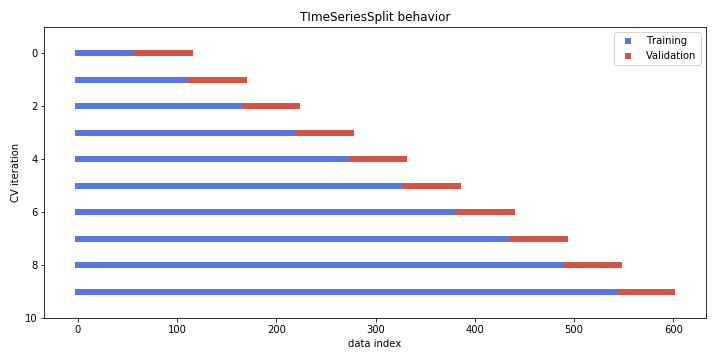

Parameters:

- test_size: Used to limit the size of the test set. Defaults to n_samples // (n_splits + 1), which is the maximum allowed value with gap=0.

- n_splits: Number of splits. Must be at least 2.

- gap: Number of samples to exclude from the end of each train set before the test set.

Time Series cross-validator (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [5]:
# tss = TimeSeriesSplit(test_size=24*10, n_splits=3, gap = 0) # 10 days prediction with 0 hrs between train and test data
## tss.split(data) is time series split object iterable, TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
## for each iteration, it shows a tuple of train and test set index arrays==([trainset index array],[testset index])
tss = TimeSeriesSplit(n_splits=3)  

### Visualizing TimeSerisSplit Cross Validation

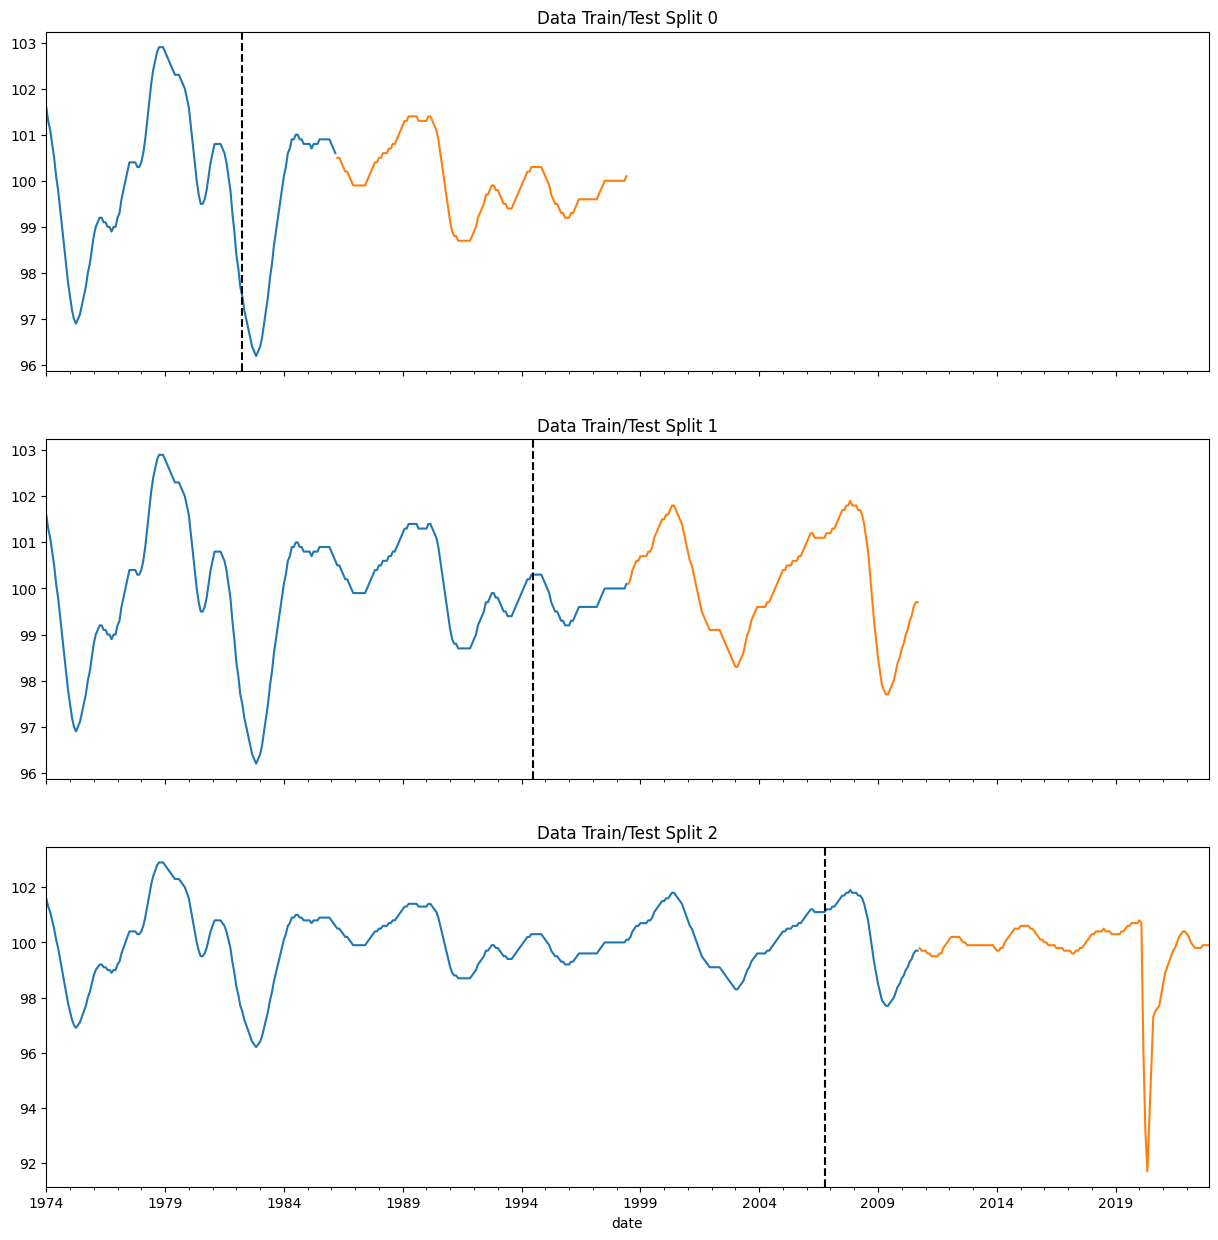

In [6]:
def vis_tss(data, varname, n_split, test_size=None, gap=0):

    tss=TimeSeriesSplit(test_size=test_size, n_splits=n_split, gap=gap)

    fig, axs = plt.subplots(n_split, 1, figsize = (15,15), sharex = True) #Number of plots according to n_splits
    split = 0

    for train_index, test_index in tss.split(data):
        train_df = xy_data.iloc[train_index]
        test_df = xy_data.iloc[test_index]
        
        train_df[varname].plot(ax=axs[split],
                        label = 'Training Set',
                        title = f'Data Train/Test Split {split}')
        test_df[varname].plot(ax=axs[split],
                        label = 'Testing Set')
        axs[split].axvline(test_index.min(), color = 'black', ls='--')

        
        split +=1
        
        

vis_tss(xy_data, 'GDP_N', n_split=3)

# Clustering (Bisecting KMeans)

* https://scikit-learn.org/stable/modules/generated/sklearn.cluster.BisectingKMeans.html#sklearn.cluster.BisectingKMeans

In [4]:

# X = np.array([[1, 2], [1, 4], [1, 0],
#                [10, 2], [10, 4], [10, 0],
#                [10, 6], [10, 8], [10, 10]])
# bisect_means = BisectingKMeans(n_clusters=3, random_state=0).fit(X)
# bisect_means.labels_
# bisect_means.predict([[0, 0], [12, 3]])
# bisect_means.cluster_centers_

In [19]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import BisectingKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_completeness_v_measure as hcv

In [6]:
## use stationary version of data
metadata=pd.read_csv('../data/full_info.csv')


X_data=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
y_data=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)

In [7]:
## train, test split
test_year=5

X_train=X_data[:-(test_year*12)]  
X_test=X_data[-(test_year*12):] 

y_train=y_data[:-(test_year*12)]  
y_test=y_data[-(test_year*12):] 


X_train.shape, X_test.shape

((528, 197), (60, 197))

In [8]:
features=list(X_train.columns)

labels=[metadata[metadata['id']==feature]['group'].values for feature in features]
labels=np.array(labels).flatten()

In [9]:
## standard scaling for training dataset only 
sc = StandardScaler()
X_scaled_train = sc.fit_transform(X_train)
X_scaled_test=sc.transform(X_test)
X_train_f=X_scaled_train.T  ## #features * #timestamp

In [10]:
## KMean Bisecting Clustering
bisect_means = BisectingKMeans(n_clusters=10, random_state=14).fit(X_train_f)
pred_label=bisect_means.labels_
#bisect_means.predict(X_train_f)
#print(bisect_means.cluster_centers_)

C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [11]:
cluster_list=[3,4,5,6,7,8,9,10]
cluster_dict={'n_cluster':[],'model':[], 'pred':[],'homo':[],'comp':[],'v_measure':[]}

for cluster in cluster_list:
    bisect_means = BisectingKMeans(n_clusters=cluster, random_state=14).fit(X_train_f)
    pred_label=bisect_means.labels_
    scores=hcv(labels, pred_label, beta=1.2)  ## completeness same as recall seems to be more important then completeness
    
    homo=scores[0]
    comp=scores[1]
    v_measure=scores[2]
    
    cluster_dict['n_cluster'].append(cluster)
    cluster_dict['model'].append(bisect_means)
    cluster_dict['pred'].append(bisect_means.labels_)
    cluster_dict['homo'].append(homo)
    cluster_dict['comp'].append(comp)
    cluster_dict['v_measure'].append(v_measure)
    
cluster_result=pd.DataFrame(cluster_dict)

with open('../result/cluster_result.pkl','wb') as f:
    pickle.dump(cluster_result, f)
    

C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserW

In [12]:
cluster_result.sort_values('v_measure', ascending=False)

,n_cluster,model,pred,homo,comp,v_measure
5,8,BisectingKMeans(random_state=14),"[0, 0, 5, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.412138,0.428288,0.420793
7,10,"BisectingKMeans(n_clusters=10, random_state=14)","[0, 0, 6, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.437617,0.406811,0.420258
6,9,"BisectingKMeans(n_clusters=9, random_state=14)","[0, 0, 6, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.427232,0.414515,0.420200
4,7,"BisectingKMeans(n_clusters=7, random_state=14)","[0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.359598,0.413030,0.386899
3,6,"BisectingKMeans(n_clusters=6, random_state=14)","[0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.334338,0.419148,0.375816
1,4,"BisectingKMeans(n_clusters=4, random_state=14)","[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.252734,0.419301,0.322645
2,5,"BisectingKMeans(n_clusters=5, random_state=14)","[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.263432,0.376643,0.315092
0,3,"BisectingKMeans(n_clusters=3, random_state=14)","[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.186804,0.369353,0.255751


<AxesSubplot:>

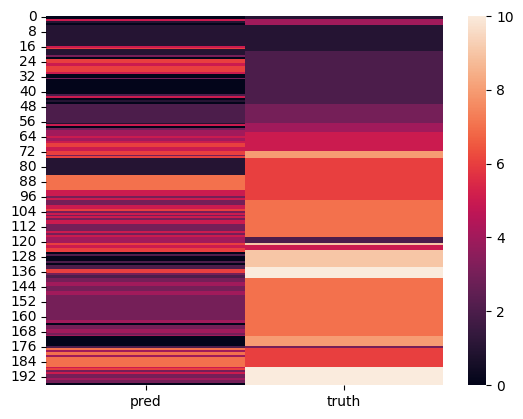

In [47]:
import seaborn as sns

pred_8=cluster_result[cluster_result.n_cluster==8]['pred']
data=pd.DataFrame({'name':features,'pred':pred_8.values[0], 'truth':labels})

sns.heatmap(data[['pred','truth']])

In [50]:
map_dict={}

for idx, feature in enumerate(data['name']):
    map_dict[feature]=data['pred'][idx] 

In [53]:
metadata['group_kmean8']=metadata['id'].map(map_dict)

In [55]:
metadata.to_csv('../data/full_info.csv')

C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.07421694888933444
For n_clusters = 4 The average silhouette_score is : 0.09676272946742899


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.09543236036936653


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.09921103181295199


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.10284223825190185


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.10474313378116158


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.12046652004232293


C:\Users\gredi\anaconda3\lib\site-packages\sklearn\cluster\_bisect_k_means.py:246: UserWarning: BisectingKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.12141657438182465


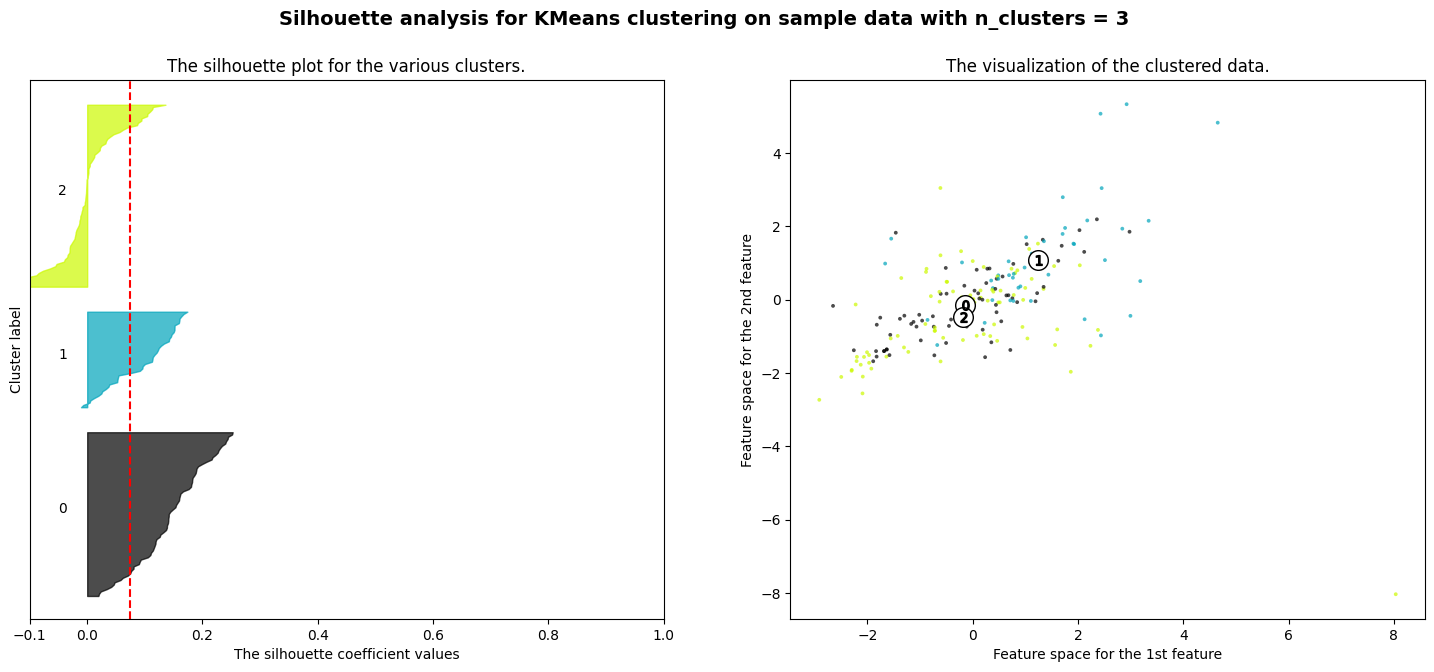

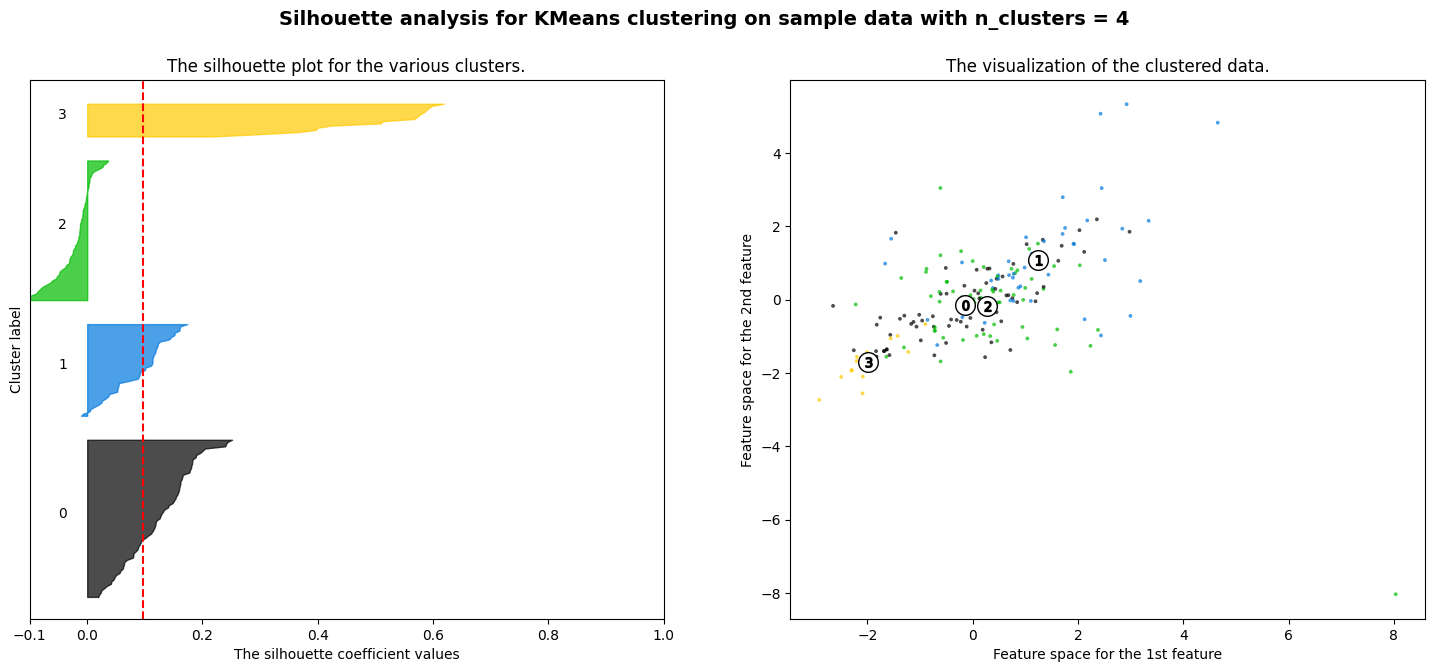

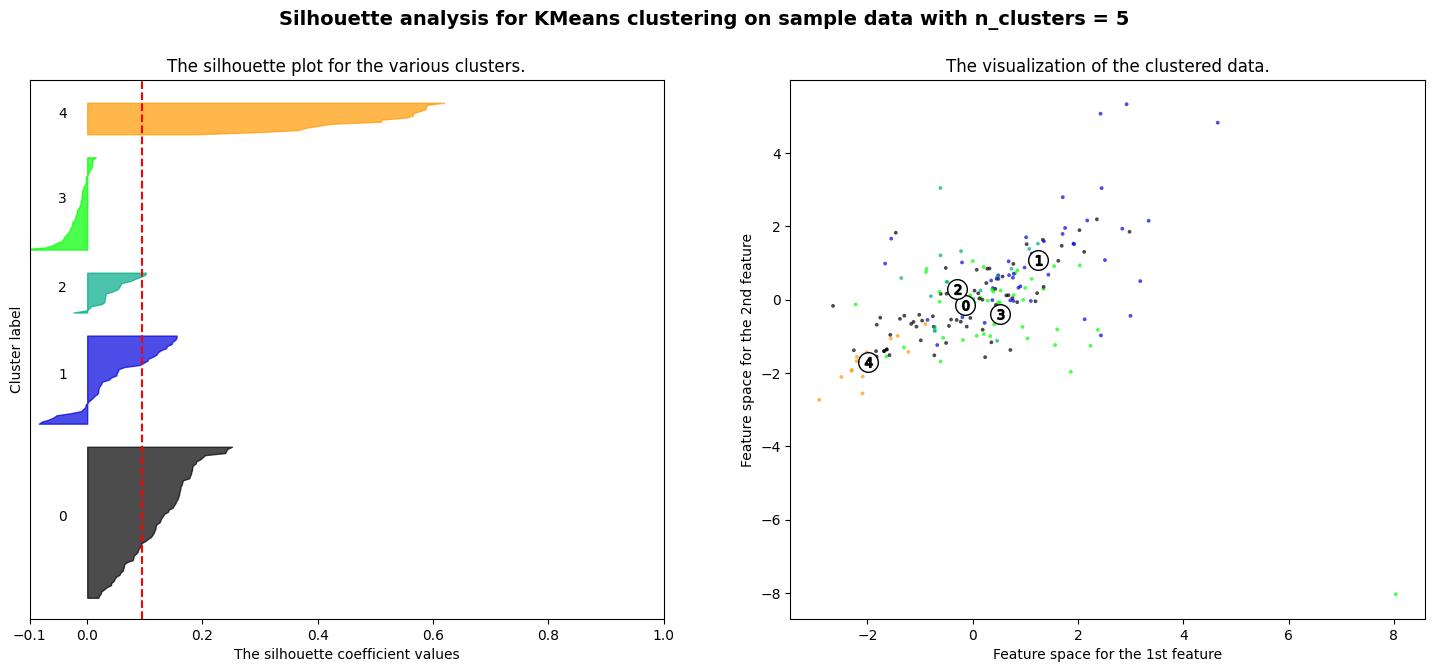

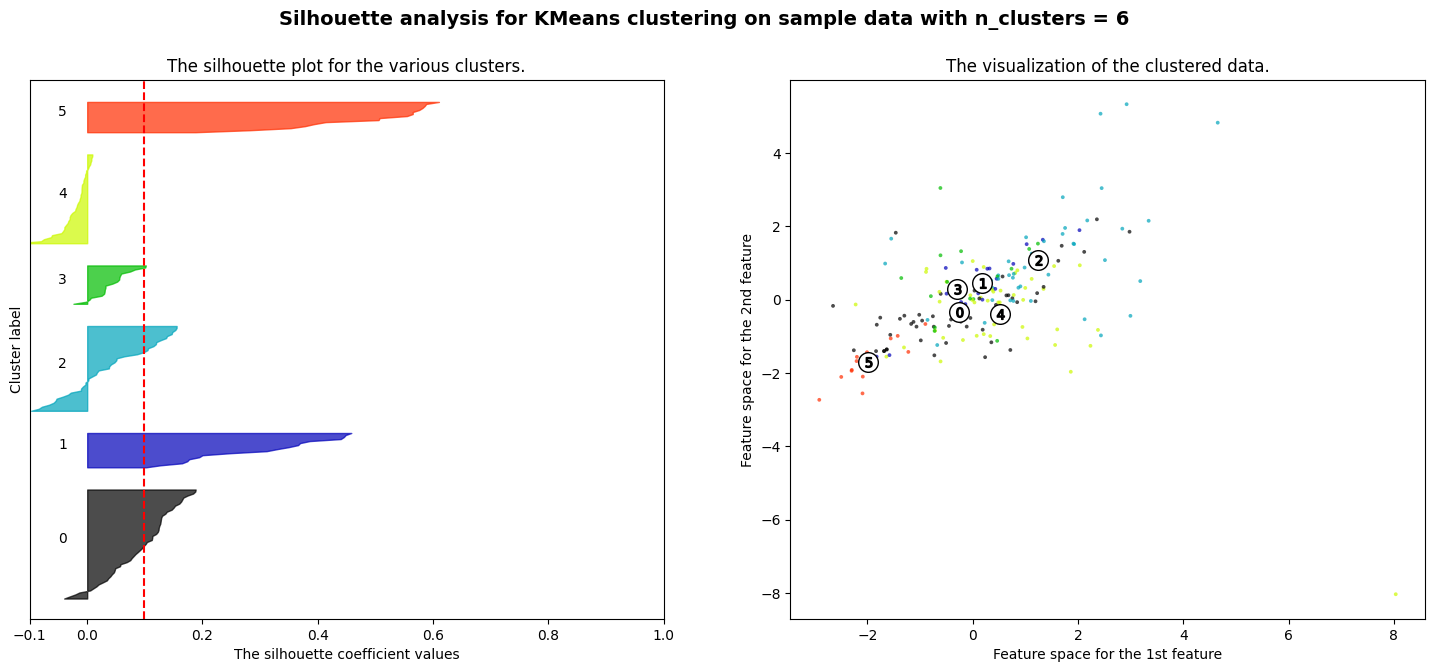

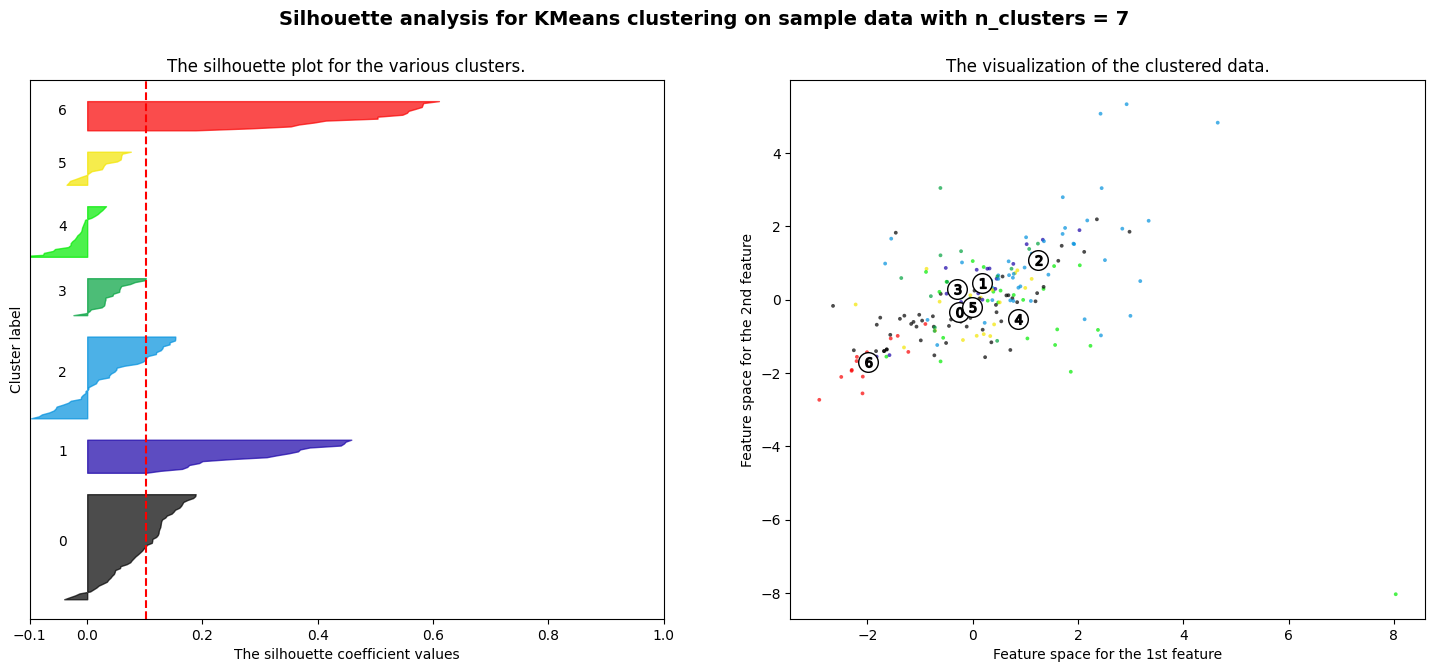

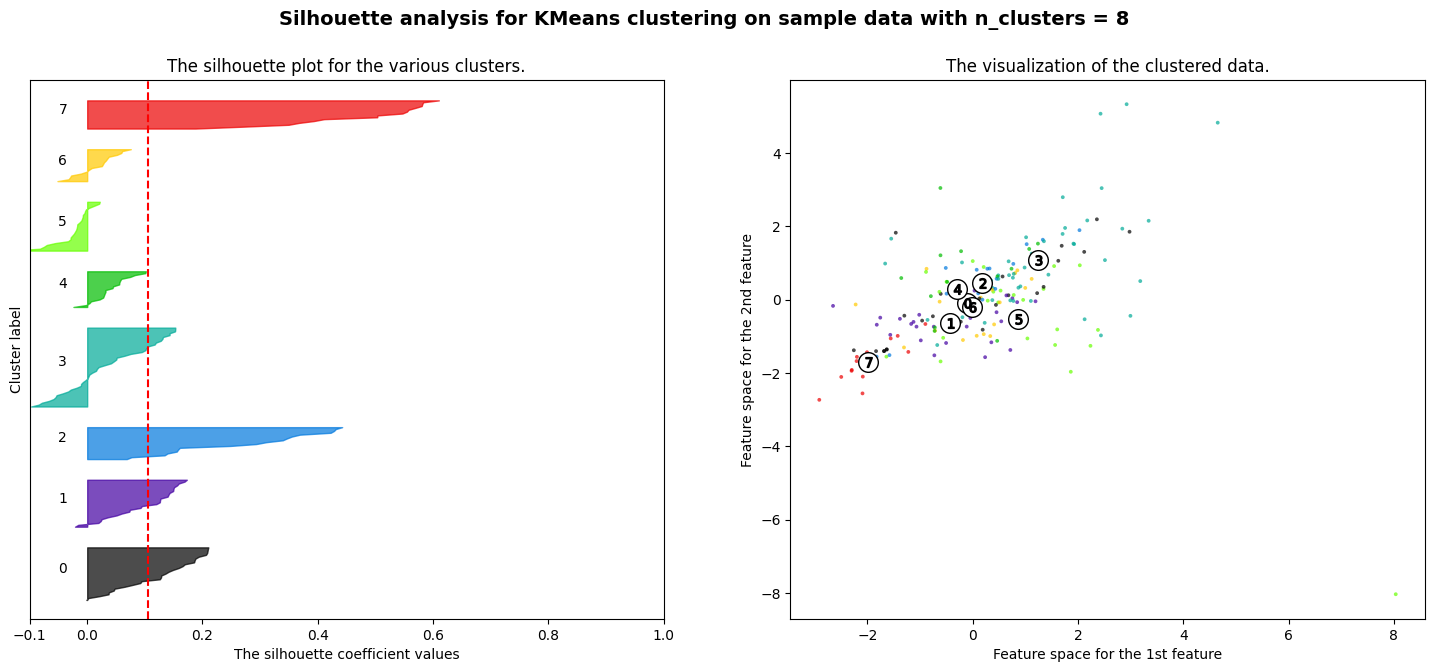

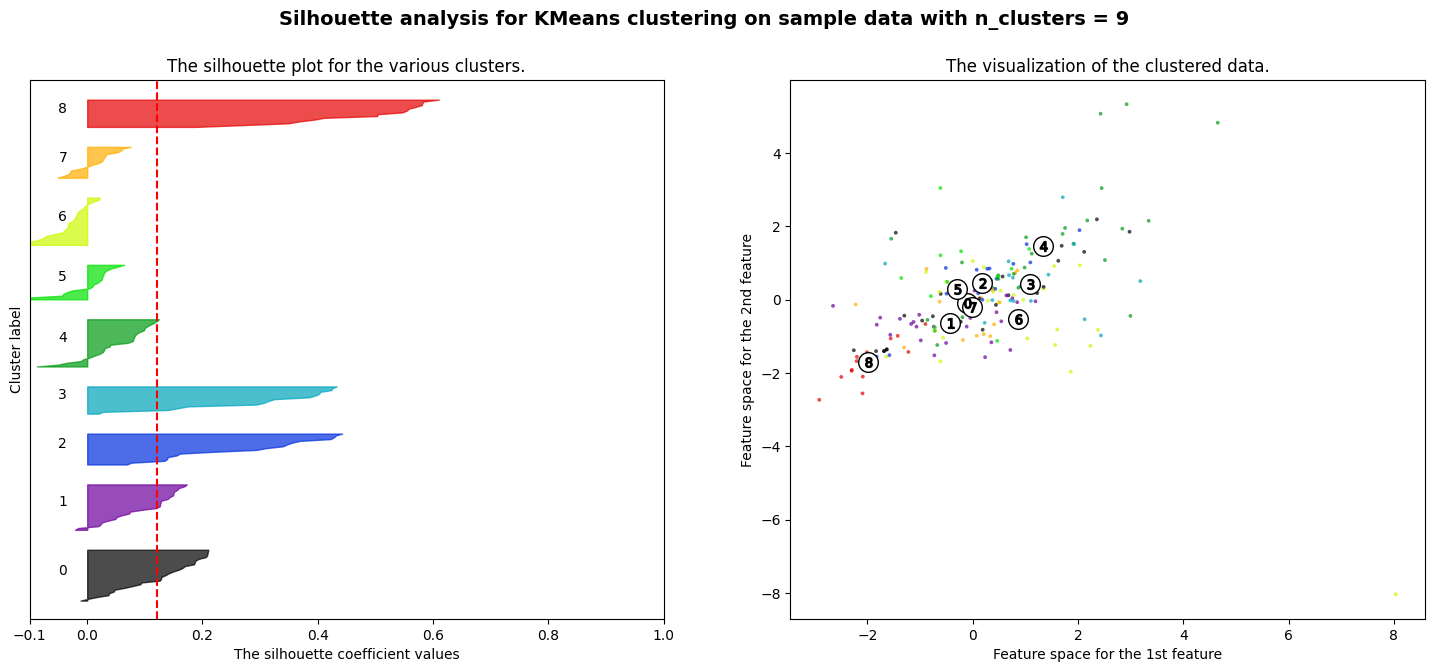

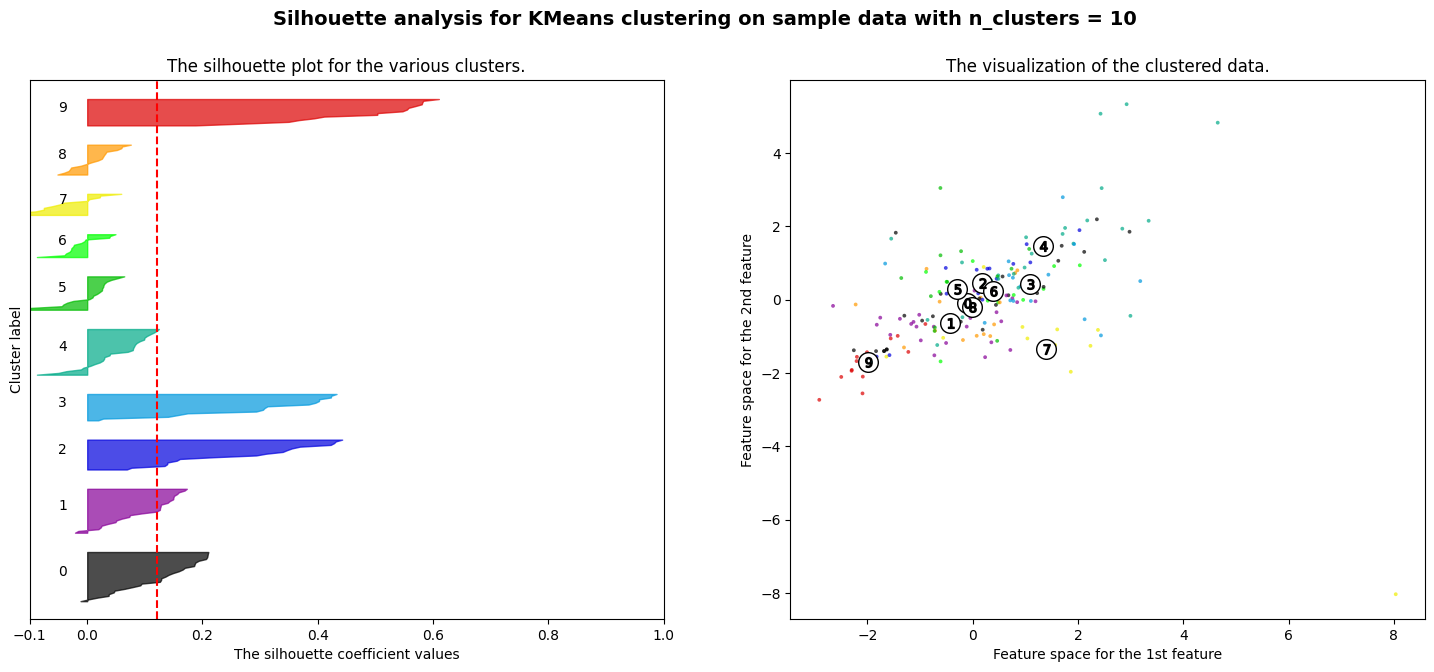

In [21]:
import plot_kmeans_silhouette_analysis
from plot_kmeans_silhouette_analysis import *
from sklearn.metrics import classification_report

plot_sil(cluster_list, X_train_f, labels)

# Principle Component Analysis (PCA)

In [9]:
X_data=pd.read_csv('../data/X_data_tr.csv', index_col='date', parse_dates=True)
y_data=pd.read_csv('../data/y_data_tr.csv', index_col='date', parse_dates=True)

#X_data.columns, y_data.columns

In [10]:
# Quick feature selection and drop na
##selected_cols = ['INDPRO', 'HOUST', 'S&P 500', 'INVEST', 'H8B3053NCBCMG', 'CPIOGSNS', 'y_nber']
# selected_cols=X_data.columns
# df = full_data[selected_cols]
# df = df.dropna(axis=0)

# Independent Variables X
# X = df.drop(['y_nber'], axis=1)
X = X_data
# Dependent Variable y
y = y_data['y_oecd'] # Target variable

In [12]:
# Applying a standard scaler transform on the independent variables prior to PCA
# Creating a standard scaler object

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [13]:
# Creating the PCA object and applying PCA to the dependent variables
# Assume 6 PCs
pca = PCA(n_components= 20)  #n_components= 6
X_pc = pca.fit_transform(X_scaled)

In [14]:
# The percentage of the variance explained by each PC
print(pca.explained_variance_ratio_)

[0.14741269 0.1079784  0.06745761 0.05216033 0.04324667 0.04190329
 0.03265572 0.02897078 0.02381195 0.01945081 0.01807478 0.01576936
 0.01483702 0.01379417 0.01224951 0.01199593 0.01123226 0.01109276
 0.0107129  0.00996213]


### PC Importance by information gain

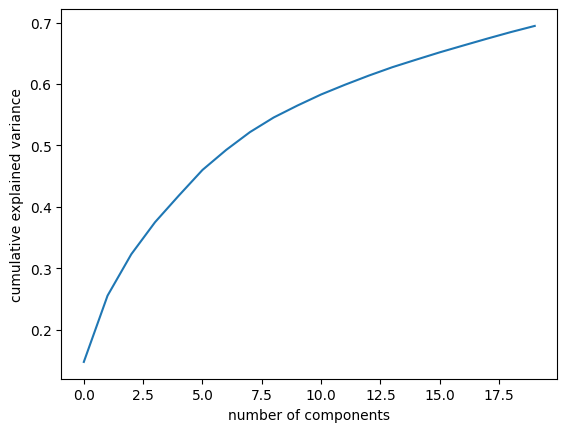

In [15]:
# To better understand the importance of the PCs, we can plot the cummulative variance explained 
# as we add more PCs. We can then observe the information gain and see when it makes sense to stop adding
# more PCs. In the below case we can see that we can stop at 4 PCs as the 5th did not add much more information
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### PC importance by vector plot

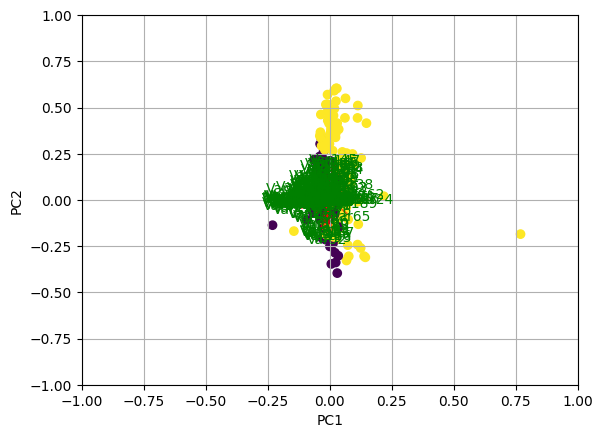

In [16]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(X_pc[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

https://stackoverflow.com/questions/50796024/feature-variable-importance-after-a-pca-analysis

The importance of each feature is reflected by the magnitude of the corresponding values in the eigenvectors (higher magnitude is equivalent to higher importance)

### PC importance by variance explained

Below we can check the amount of variance explained by each component and the ratio of variance explained by each component

In [17]:
# The PCA class contains explained_variance_ratio_ which returns the variance explained by each principal components.
print(pca.explained_variance_)

[29.08977313 21.30798192 13.31178794 10.29308974  8.53410681  8.26901114
  6.4441365   5.71696727  4.69894605  3.83833705  3.56679846  3.1118553
  2.92787291  2.7220808   2.41726542  2.36722362  2.21652435  2.18899581
  2.1140373   1.96588268]


In [18]:
# The percentage of the variance explained by each PC
print(pca.explained_variance_ratio_)

[0.14741269 0.1079784  0.06745761 0.05216033 0.04324667 0.04190329
 0.03265572 0.02897078 0.02381195 0.01945081 0.01807478 0.01576936
 0.01483702 0.01379417 0.01224951 0.01199593 0.01123226 0.01109276
 0.0107129  0.00996213]


PC1 explains 60% , PC2 9% and PC3 6%. Together, if we keep PC1, PC2and PC3 only, they explain 75%.

Now, let's find the most important features.

In [19]:
print(abs(pca.components_))

[[0.03025981 0.09424591 0.13090286 ... 0.00414419 0.00610324 0.00589691]
 [0.00822731 0.00885498 0.01106327 ... 0.04216996 0.05267345 0.02785933]
 [0.05986554 0.00506726 0.09623237 ... 0.0311129  0.04392858 0.0931987 ]
 ...
 [0.16014688 0.03461584 0.03077966 ... 0.29288172 0.09217043 0.0163775 ]
 [0.10565782 0.11196736 0.00208331 ... 0.1985171  0.01931855 0.02324046]
 [0.06325467 0.06116931 0.04918971 ... 0.11889533 0.07024488 0.02775414]]


pca.components_ has shape [n_components, n_features]. Thus, by looking at the PC1 (First Principal Component) which is the first row: [[0.47563124 0.17172633 0.48330892 0.4967887  0.07456869 0.50826959]] we can conclude that feature 1, 3 ,4 and 6 (or Var 1, 3 , 4 and 6 in the biplot) are the most important, while variables 2 and 5 are less important. This is also clearly visible from the biplot.

### Most important features by highest influence on the PCs

The important features are the ones that influence more the components and thus, have a large absolute value/score on the component.

To get the most important features on the PCs with names:

In [20]:
# Number of components
n_pcs= pca.components_.shape[0]
print(n_pcs)

20


In [21]:
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [X_data.columns[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_most_important = pd.DataFrame(dic.items()).rename(columns={0:'PC', 1:'var'})
df_most_important['description']=df_most_important['var'].apply(lambda x:full_info[full_info.id==x]['title'].values[0])
df_most_important['group']=df_most_important['var'].apply(lambda x:full_info[full_info.id==x]['group'].values[0])


In [22]:
df_most_important


,PC,var,description,group
0,PC0,USGOOD,"All Employees, Goods-Producing",2
1,PC1,CPIAUCNS,Consumer Price Index for All Urban Consumers: ...,7
2,PC2,PERMIT,New Privately-Owned Housing Units Authorized i...,3
3,PC3,CUSR0000SAC,CPI : Commodities,7
4,PC4,GS5,Market Yield on U.S. Treasury Securities at 5-...,6
5,PC5,5Y3M,5Y minus 3M,6
6,PC6,GS1,Market Yield on U.S. Treasury Securities at 1-...,6
7,PC7,S&P: indust,S&P's Common Stock Price Index: Industrials,8
8,PC8,H8B1151NCBCMG,"Total Assets, All Commercial Banks",10
9,PC9,1Y6M,1Y minus 6M,6


In [ ]:
### finding clusters using 

### Running PCA on features according to their code group in metadata

In [23]:
#X_data.head()
#full_info.head()

In [24]:
full_info['group'].unique()

array([ 1,  4,  2,  3,  5,  8,  6,  7,  9,  0, 10], dtype=int64)

In [25]:
group = full_info[full_info['group']==1]
group_feature_names = list(group['id'])

In [26]:
len(group_feature_names)

16

In [27]:
subset = X_data[group_feature_names]
subset = subset.dropna(axis=0)

In [28]:
# This step is to select numeric features within the group
# This will be replaced by encoding

# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# n_df = subset.select_dtypes(include=numerics)

In [29]:
n_df=subset

In [30]:
# Preparation for PCA
sc = StandardScaler()
scaled = sc.fit_transform(n_df)

# PCA
pca = PCA()
pc = pca.fit_transform(scaled)

n_pcs= pca.components_.shape[0]

In [31]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

# get the names
most_important_names = [group_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_most_important = pd.DataFrame(dic.items())

In [32]:
df_most_important

,0,1
0,PC0,IPMANSICS
1,PC1,IPB51222S
2,PC2,RPI
3,PC3,W875RX1
4,PC4,IPFUELS
5,PC5,W875RX1
6,PC6,IPB51222S
7,PC7,IPBUSEQ
8,PC8,IPDMAT
9,PC9,IPMAT


In [33]:
pca.components_[0]

array([ 0.02278155, -0.16114135, -0.31233628, -0.31111084, -0.30517637,
       -0.28452533, -0.27795336, -0.17983426, -0.28325034, -0.27881388,
       -0.2862917 , -0.19903602, -0.31285962,  0.0161675 , -0.15088031,
       -0.30827138])

In [34]:
np.around(pca.explained_variance_ratio_, 3)

array([0.618, 0.109, 0.072, 0.065, 0.041, 0.035, 0.023, 0.015, 0.012,
       0.007, 0.002, 0.001, 0.001, 0.   , 0.   , 0.   ])

In [35]:
dic

{'PC0': 'IPMANSICS',
 'PC1': 'IPB51222S',
 'PC2': 'RPI',
 'PC3': 'W875RX1',
 'PC4': 'IPFUELS',
 'PC5': 'W875RX1',
 'PC6': 'IPB51222S',
 'PC7': 'IPBUSEQ',
 'PC8': 'IPDMAT',
 'PC9': 'IPMAT',
 'PC10': 'CUMFNS',
 'PC11': 'IPFPNSS',
 'PC12': 'IPFINAL',
 'PC13': 'IPFINAL',
 'PC14': 'IPMANSICS',
 'PC15': 'INDPRO'}

In [36]:
X_data.head()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,H8B1047NCBCMG,H8B1048NCBCMG,H8B1058NCBCMG,H8B1091NCBCMG,H8B1151NCBCMG,H8B1152NCBCMG,H8B3053NCBCMG,H8B3094NCBCMG,H8B3095NCBCMG,H8B3305NCBCMG
date,,,,,,,,,,,,,,,,,,,,,
1974-01-01,-0.008564,-0.011916,-0.000559,0.000901,0.012460,-0.006620,-0.006027,-0.009055,-0.013168,-0.051689,...,95.7,27.1,1.7,114.0,12.7,-1.9,-29.5,-4.9,-53.5,-18.7
1974-02-01,-0.006029,-0.006476,-0.005798,-0.004919,0.005931,-0.002892,-0.003727,-0.002490,-0.003025,-0.001971,...,-64.4,21.9,-2.1,56.4,8.8,1.1,23.8,-29.6,70.8,-2.4
1974-03-01,-0.006566,-0.006938,0.001562,0.003376,0.014301,-0.000165,0.002957,0.003684,0.001733,0.000346,...,42.6,2.3,7.5,56.4,16.8,10.2,33.9,45.6,33.4,25.0
1974-04-01,-0.000595,-0.004942,0.003335,-0.007316,0.013271,-0.003038,-0.004562,-0.005242,-0.003045,-0.007320,...,65.8,-6.8,31.2,-57.8,16.8,29.6,30.9,53.7,-8.1,42.0
1974-05-01,0.000902,0.000657,0.002920,0.004392,0.011373,0.008044,0.009300,0.010782,0.009367,0.004069,...,39.0,21.6,4.9,0.8,7.4,8.5,2.0,93.4,30.0,23.7


### Finding most important features per feature type in a loop

### Replace line 28 and 29 with list and append row to df

In [63]:
##numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Looping through all possible feature types by code

def select_features(metadata, X, threshold, criteria='cum'):  ## criteria can be 'cum' or None (non-cumulative)

    n=len(metadata['group'].unique())-1

    for code in range(n):
        # # separating a group of features which have the same code
        group = metadata[metadata['group']==code+1]
        # # getting the names of these features from the metadata df
        group_feature_names = list(group['id'])
        # # creating a subset of the full_data df having only features with the same code


        selected_cols=[colname for colname in group_feature_names if colname in X.columns]

    #    print(selected_cols)

        data = X[selected_cols]

        # dropping nan rows
        # subset = subset.dropna(axis=0)
        # Getting rid of categorical features within the group, this will be replaced by encoding
        # n_df = subset.select_dtypes(include=numerics)
        # Running feature scaling and PCA
        sc = StandardScaler()
        scaled = sc.fit_transform(data)
        # PCA
        pca = PCA() # with no number of target PCs defined will not do any reduction
        pc = pca.fit_transform(scaled)
        n_pcs= pca.components_.shape[0]
#        print(pca.components_.shape[1])
        # getting the most important features and their names within this feature group
        most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
        # get the names
        most_important_names = [data.columns[most_important[i]] for i in range(n_pcs)]
        # Creating a dictionary to summarize features and importance into a dataframe
        
        dic = {'PC':['PC{}'.format(i) for i in range(n_pcs)],
            'variable':[most_important_names[i] for i in range(n_pcs)],
            'var_ratio':[pca.explained_variance_ratio_[i] for i in range(n_pcs)],
            'var_ratio_cum':np.cumsum([pca.explained_variance_ratio_[i] for i in range(n_pcs)]),
            'group':[code+1]*len(range(n_pcs))
        }
        
        if criteria=='cum':
            c_var='var_ratio_cum'
            threshold_idx=np.argwhere((dic[c_var]>threshold)*np.ones(n_pcs,dtype=int)==1).min()
            dic['select']=[1 if x<=threshold_idx else 0 for x in range(n_pcs)]
            
        else:
            c_var='var_ratio'
            threshold_idx=np.where(np.array(dic[c_var])>threshold)
            dic['select']=[1 if x in list(threshold_idx[0]) else 0 for x in range(n_pcs)]

        if code==0:
            df_most_important = pd.DataFrame(dic)
        
        else:
            df=pd.DataFrame(dic)
            df_most_important=pd.concat([df_most_important, df], axis=0, ignore_index=True)
    
    # build the dataframe
    df_most_important['title']=df_most_important['variable'].apply(lambda x:metadata[metadata.id==x]['title'].values[0])
    

    return df_most_important


In [86]:
df_feature=select_features(full_info, X_data, 0.5, criteria='cum')
len(df_feature[df_feature.select==1])

20

In [84]:
df_feature.to_csv('../data/df_feature.csv', index = False, header=True)
df_feature[df_feature.select==1]

,PC,variable,var_ratio,var_ratio_cum,group,select,title
0,PC0,IPMANSICS,0.617695,0.617695,1,1,Industrial Production: Manufacturing (SIC)
16,PC0,PAYEMS,0.435164,0.435164,2,1,"All Employees, Total Nonfarm"
47,PC0,HOUST,0.760762,0.760762,3,1,New Privately-Owned Housing Units Started: Tot...
58,PC0,ISRATIOx,0.467138,0.467138,4,1,Total Business: Inventories to Sales Ratio
79,PC0,T10YFFM,0.363146,0.363146,6,1,10-Year Treasury Constant Maturity Minus Feder...
162,PC0,WILL5000INDFC,0.599206,0.599206,8,1,Wilshire 5000 Total Market Full Cap Index
163,PC1,S&P PE ratio,0.335516,0.934722,8,1,S&P's Composite Common Stock: Price-Earnings R...
171,PC0,BSI,0.523465,0.523465,9,1,business survey(manufacturing): Confidence in...


In [76]:
# To better understand the importance of the PCs, we can plot the cummulative variance explained 
# as we add more PCs. We can then observe the information gain and see when it makes sense to stop adding
# more PCs. In the below case we can see that we can stop at 4 PCs as the 5th did not add much more information


## selected feature dataframe, metadata dataframe, k=number of columns in subplots 
def plot_pca(df_feature, metadata, k=3):

    n=len(metadata['group'].unique())-1

    if n%k==0:
        n_row=n//k
        n_col=k

    else:
        n_row=n//k+1
        n_col=k

    fig, ax=plt.subplots(nrows=n_row, ncols=n_col, figsize=(5*n//k, 15))

    for code in range(n):

        if (code+1)%k==0:
            r=(code+1)//k-1
            c=n_col-1
        else:
            r=(code+1)//k
            c=(code+1)%k-1


        data=df_feature[df_feature.group==code+1]['var_ratio_cum'][:10]
        ax[r,c].plot(list(range(len(data))), data)
        ax[r,c].set_title('group{}'.format(code+1))
        ax[r,c].set_xlabel('number of components')
        ax[r,c].set_ylabel('explained var(cum)')
        plt.tight_layout();

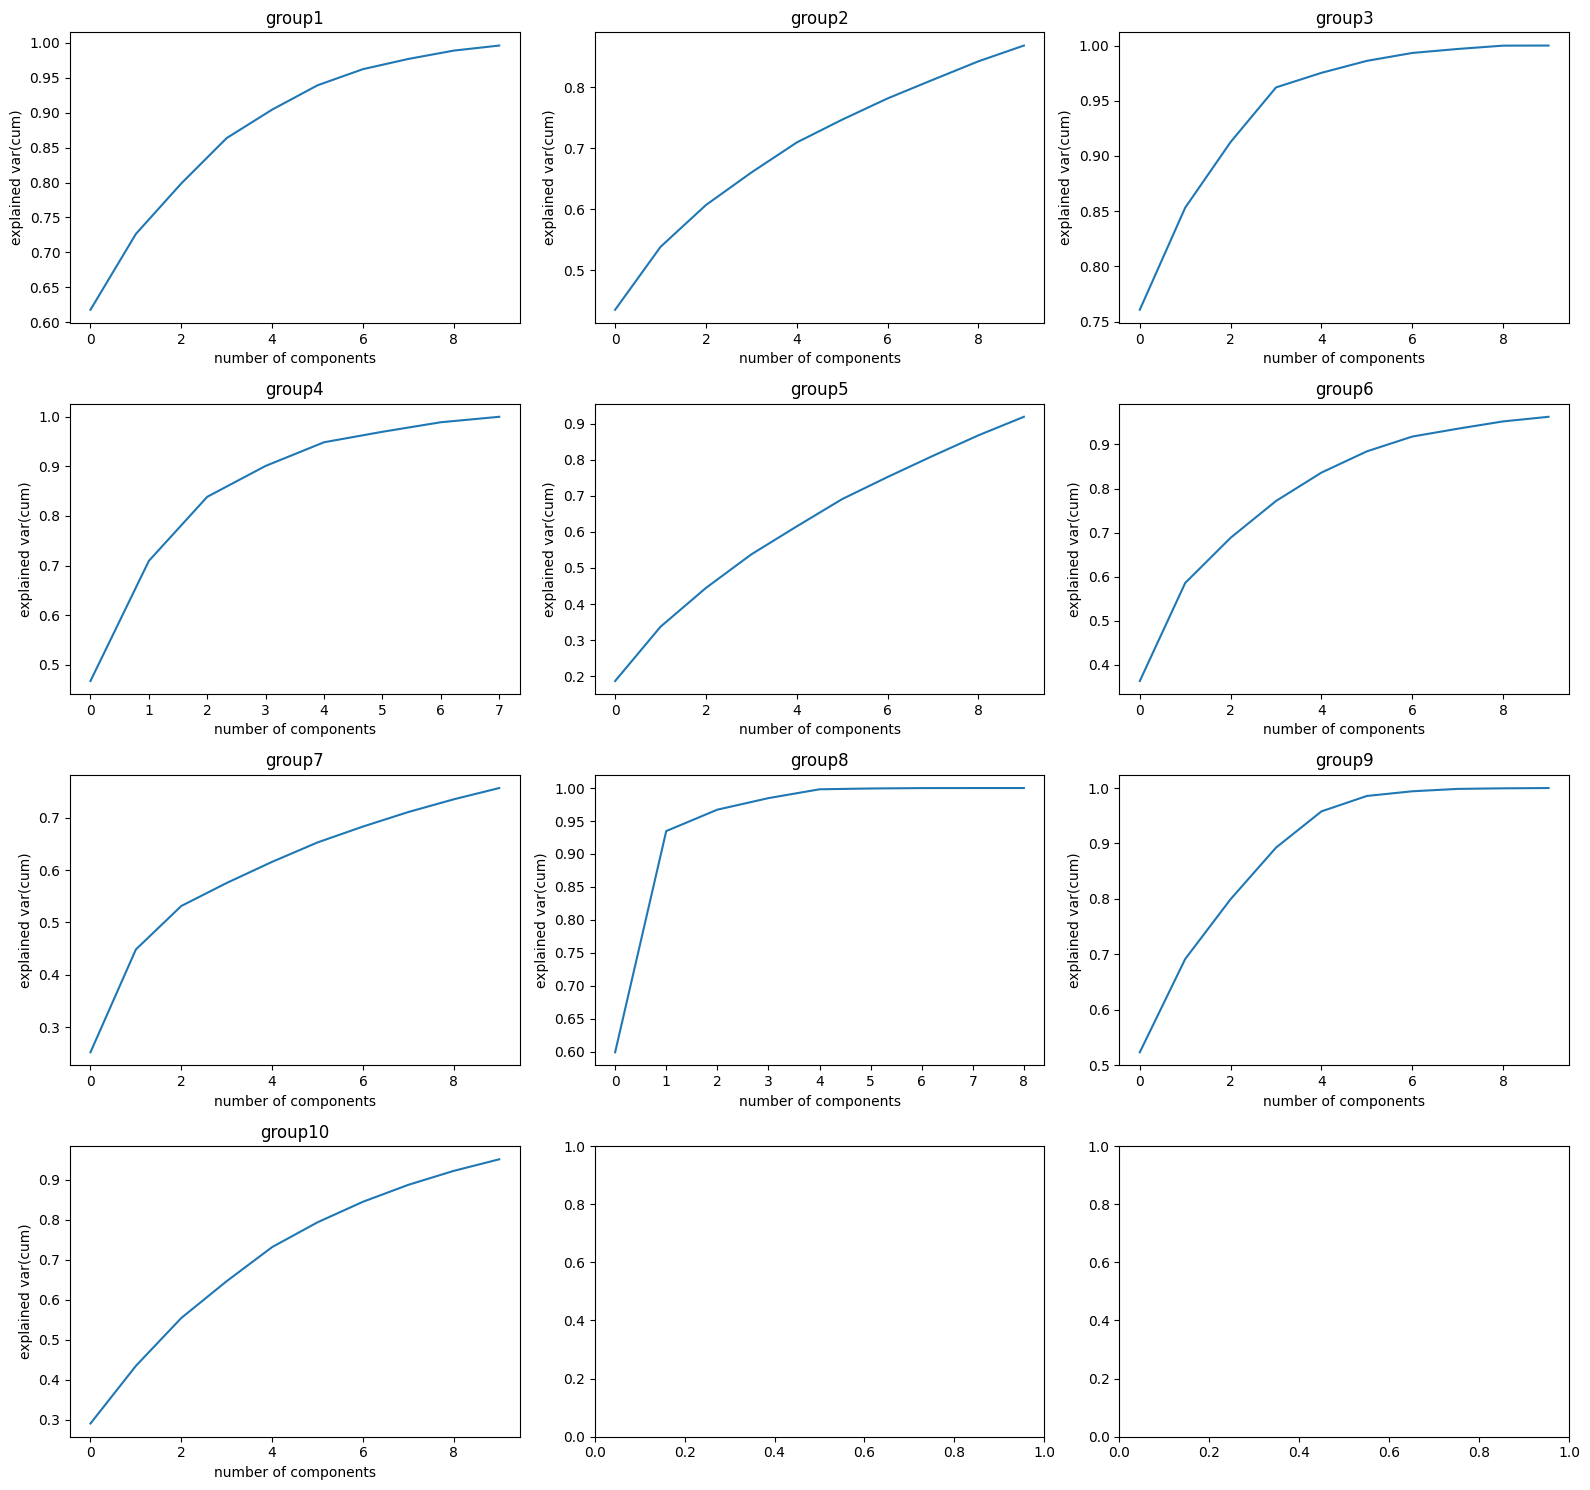

In [41]:
plot_pca(df_feature, full_info)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a63e5aef-5b52-4e97-916a-2439a8b479ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>